In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def cppi(asset,rf=0,floor=0.9,cushion_multiple=5):
  n = asset.shape[0]
  port_value = []
  port_value.append(asset[0])
  cushion = port_value[0] * (1-floor)
  risky_asset = cushion * cushion_multiple
  risk_free_asset = port_value[0] - risky_asset
  
  for i in range(1,n):
    port_value.append((asset[i]/asset[i-1])*risky_asset + risk_free_asset*(1+rf))
    cushion_new = port_value[i] - port_value[0]*floor
    risky_asset = cushion_new * cushion_multiple
    risk_free_asset = port_value[i] - risky_asset 
   
  return port_value


In [3]:
sensex = yf.download("^BSESN")
sensex.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-07-01,4263.109863,4301.770020,4247.660156,4300.859863,4300.859863,0
1997-07-02,4302.959961,4395.310059,4295.399902,4333.899902,4333.899902,0


In [4]:
sensex_ad = sensex['Adj Close']

In [9]:
sensex_ad.head()

Date
1997-07-01    4300.859863
1997-07-02    4333.899902
1997-07-03    4323.459961
1997-07-04    4323.819824
1997-07-07    4291.450195
Name: Adj Close, dtype: float64

In [16]:
sensex['CPPI'] = cppi(sensex_ad)

In [25]:
sensex.iloc[0:100,[4,6]].head()

,Adj Close,CPPI
Date,,
1997-07-01,4300.859863,4300.859863
1997-07-02,4333.899902,4317.379883
1997-07-03,4323.459961,4312.000732
1997-07-04,4323.819824,4312.184359
1997-07-07,4291.450195,4295.661592


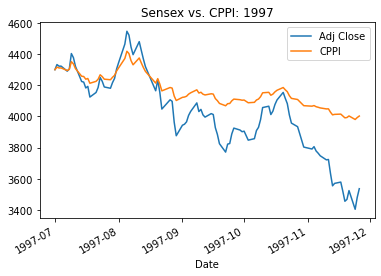

In [29]:
sensex.iloc[0:100,[4,6]].plot()
plt.title("Sensex vs. CPPI: 1997");

In [6]:
def find_nd1(S,K,rf,t,vol):
  d1 = (np.log(S/K)+(rf+vol*vol*0.5)*t)/(vol*np.sqrt(t))
  nd1 = scipy.stats.norm.cdf(d1)
  return nd1


def find_nd2(S,K,rf,t,vol):
  d1 = (np.log(S/K)+(rf+vol*vol*0.5)*t)/(vol*np.sqrt(t))
  d2 = d1 - vol*np.sqrt(t)
  nd2 = scipy.stats.norm.cdf(d2)
  return nd2


In [134]:
find_nd1(100,200,0.1,0.001,0.5)

0.0

In [16]:
find_nd2(100,90,0.1,1,0.5)

0.5638434379090567

In [140]:
def obpi(asset, rf=0.1,floor = 0.9,vol = 0.5,t = 1):
  n = asset.shape[0]
  #   asset = list(asset)
  port_value = []
  risky_asset=[]
  risk_free_asset=[]
    
  port_value.append(asset[0])
  S = asset[0]
  K = asset[0]*floor
  nd1 = find_nd1(S=S,K=K,rf=rf,t=t,vol=vol)
  nd2 = find_nd2(S=S,K=K,rf=rf,t=t,vol=vol)
  num = S*nd1
  den = S*nd1 + K*np.exp(-rf*t)*nd2
  alpha = num/den
  risky_asset.append(asset[0]*alpha)
  risk_free_asset.append(port_value[0] - risky_asset[0])
  days = t*255  
  
  for i in range(1,n):
    port_value.append((asset[i]/asset[i-1])*risky_asset[i-1] + risk_free_asset[i-1]*(1+rf/255))
    S=asset[i]
    t = (days-i)/255
    nd1 = find_nd1(S=S,K=K,rf=rf,t=t,vol=vol)
    nd2 = find_nd2(S=S,K=K,rf=rf,t=t,vol=vol)
    num = S*nd1
    den = S*nd1 + K*np.exp(-rf*t)*nd2
    alpha = num/den
    risky_asset.append(asset[i]*alpha)
    risk_free_asset.append(port_value[i] - risky_asset[i])
      
  return port_value, risky_asset, risk_free_asset

In [148]:
sensex_obpi = obpi(sensex_ad[:100])[0]

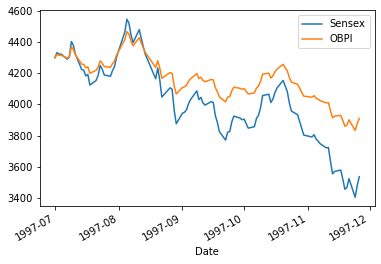

In [149]:
df = sensex_ad[:100].to_frame(name='Sensex')
df['OBPI']=sensex_obpi
df.plot();